## Data 

In [32]:
from sklearn.datasets import load_breast_cancer
import pandas as pd
import numpy as np

data = load_breast_cancer()

df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target

print(df)



     mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0          17.99         10.38          122.80     1001.0          0.11840   
1          20.57         17.77          132.90     1326.0          0.08474   
2          19.69         21.25          130.00     1203.0          0.10960   
3          11.42         20.38           77.58      386.1          0.14250   
4          20.29         14.34          135.10     1297.0          0.10030   
..           ...           ...             ...        ...              ...   
564        21.56         22.39          142.00     1479.0          0.11100   
565        20.13         28.25          131.20     1261.0          0.09780   
566        16.60         28.08          108.30      858.1          0.08455   
567        20.60         29.33          140.10     1265.0          0.11780   
568         7.76         24.54           47.92      181.0          0.05263   

     mean compactness  mean concavity  mean concave points  mea

## Node class

In [33]:
class Node():
    def __init__(self,featureIndex = None ,threshold = None,left = None ,right = None,infoGain = None ,value = None ):
        
        self.featureIndex = featureIndex
        self.threshold = threshold 
        self.left = left 
        self.right = right 
        self.infoGain = infoGain

        self.value = value 


## Tree class

In [34]:
import numpy as np
import pandas as pd

class DecisionTree():
    def __init__(self, minSamples, maxDepth, class_names=None):
        self.minSamples = minSamples
        self.maxDepth = maxDepth
        self.root = None
        self.class_names = class_names  

    def buildTree(self, dataset, currDepth=0):
        X, Y = dataset.iloc[:, :-1], dataset.iloc[:, -1]
        numSamples, numCols = dataset.shape
        numFeatures = numCols - 1

       # leaf node 
        if numSamples <= self.minSamples or currDepth >= self.maxDepth:
            leafValue = self.calcLeafValue(Y)
            return Node(value=leafValue)

        bestSplit = self.getBestSplit(dataset=dataset, numSamples=numSamples, numFeatures=numFeatures)
        # if no valid split found, make a leaf
        if not bestSplit or bestSplit.get("infoGain", 0) <= 0:
            leafValue = self.calcLeafValue(Y)
            return Node(value=leafValue)
        #  build subtrees
        left_subtree = self.buildTree(bestSplit["left"], currDepth + 1)
        right_subtree = self.buildTree(bestSplit["right"], currDepth + 1)
        return Node(featureIndex=bestSplit["featureIndex"], threshold=bestSplit["threshold"], left=left_subtree, right=right_subtree, infoGain=bestSplit["infoGain"])

    def getBestSplit(self, dataset, numSamples, numFeatures):
        max_IG = -float("inf")
        bestSplit = {}

        for featureIndex in range(numFeatures):
            featureSamples = dataset.iloc[:, featureIndex]
            uniqueThresholds = np.sort(np.unique(featureSamples))
            if len(uniqueThresholds) <= 1:
                continue
            possibleThresholds = (uniqueThresholds[:-1] + uniqueThresholds[1:]) / 2.0

            for threshold in possibleThresholds:
                leftDataset, rightDataset = self.split(dataset=dataset, featureIndex=featureIndex, threshold=threshold)
                if len(leftDataset) > 0 and len(rightDataset) > 0:
                    datasetTargets = dataset.iloc[:, -1]
                    leftTargets = leftDataset.iloc[:, -1]
                    rightTargets = rightDataset.iloc[:, -1]
                    datasetEntropy = self.entropy(datasetTargets)
                    leftDatasetEntropy = self.entropy(leftTargets)
                    rightDatasetEntropy = self.entropy(rightTargets)
                    IG = self.informationGain(datasetEntropy, leftDatasetEntropy, rightDatasetEntropy, datasetTargets, leftTargets, rightTargets)
                    if IG > max_IG:
                        max_IG = IG
                        bestSplit["featureIndex"] = featureIndex
                        bestSplit["threshold"] = threshold
                        bestSplit["left"] = leftDataset
                        bestSplit["right"] = rightDataset
                        bestSplit["infoGain"] = IG
        return bestSplit

    def split(self, dataset, featureIndex, threshold):
        mask = np.array(dataset.iloc[:, featureIndex]) <= threshold
        leftDataset, rightDataset = dataset[mask], dataset[~mask]
        return leftDataset, rightDataset

    def entropy(self, dataset):
        datasetEntropy = 0.0
        numberOfExamples = len(dataset)
        classesLabels = np.unique(dataset)
        for cls in classesLabels:
            p = len(dataset[dataset == cls]) / numberOfExamples
            if p > 0:
                datasetEntropy = datasetEntropy - (p * np.log2(p))
        return datasetEntropy

    def informationGain(self, datasetEntropy, leftDatasetEntropy, rightDatasetEntropy, datasetTargets, leftTargets, rightTargets):
        l_weight = len(leftTargets) / len(datasetTargets)
        r_weight = len(rightTargets) / len(datasetTargets)
        IG = datasetEntropy - (l_weight * leftDatasetEntropy + r_weight * rightDatasetEntropy)
        return IG

    def calcLeafValue(self, Y):
        classes, counts = np.unique(Y, return_counts=True)
        return classes[np.argmax(counts)]

    def fit(self, X, Y):
        dataset = pd.DataFrame(np.concatenate((X, Y), axis=1))
        self.root = self.buildTree(dataset)

    def predict(self, X):
        numeric_preds = [self.makePrediction(x, self.root) for x in X]
        if self.class_names is None:
            return numeric_preds
        # Map numeric predictions to class names
        if isinstance(self.class_names, (list, tuple)):
            return [self.class_names[int(p)] for p in numeric_preds]
        # dict format
        return [self.class_names[p] for p in numeric_preds]

    def makePrediction(self, x, tree):
        if tree.value is not None:
            return tree.value
        feature = x[tree.featureIndex]
        if feature <= tree.threshold:
            return self.makePrediction(x, tree.left)
        else:
            return self.makePrediction(x, tree.right)

    def print_tree(self, tree=None, indent=" "):
        if not tree:
            tree = self.root

        if tree.value is not None:
            # Display class name if available
            if self.class_names is not None:
                if isinstance(self.class_names, (list, tuple)):
                    label = self.class_names[int(tree.value)]
                else:
                    label = self.class_names.get(tree.value, tree.value)
                print(f'Leaf: {label}')
            else:
                print(tree.value)
        else:
            print("X_" + str(tree.featureIndex), "<=", tree.threshold, "?", tree.infoGain)
            print("%sleft:" % (indent), end="")
            self.print_tree(tree.left, indent + indent)
            print("%sright:" % (indent), end="")
            self.print_tree(tree.right, indent + indent)


## Train-Validation-Test split

In [35]:
from sklearn.model_selection import train_test_split

X = df.iloc[:,:-1].values
Y = df.iloc[:,-1].values.reshape(-1,1)

#  80% train+val, 20% test
X_trainval, X_test, Y_trainval, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=41
)

# 75% train, 25% validation (of the 80%)
X_train, X_val, Y_train, Y_val = train_test_split(
    X_trainval, Y_trainval, test_size=0.25, random_state=41
)

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

Training set size: 341
Validation set size: 114
Test set size: 114


## Hyperparameter Tuning
- Hyperparameter tuning with grid search


In [36]:

from sklearn.metrics import accuracy_score
import pandas as pd

# Define hyperparameter ranges
max_depth_values = [2, 4, 6, 8, 10]
min_samples_values = [2, 5, 10]


results = []

print("=== Grid Search Results ===\n")


for max_depth in max_depth_values:
    for min_samples in min_samples_values:
        # Train model
        clf = DecisionTree(minSamples=min_samples, maxDepth=max_depth)
        clf.fit(X_train, Y_train)
        
        # Evaluate on train and validation sets
        Y_train_pred = clf.predict(X_train)
        Y_val_pred = clf.predict(X_val)
        
        train_acc = accuracy_score(Y_train, Y_train_pred)
        val_acc = accuracy_score(Y_val, Y_val_pred)
        
        results.append({
            'max_depth': max_depth,
            'min_samples': min_samples,
            'train_accuracy': train_acc,
            'val_accuracy': val_acc
        })
        
        print(f"max_depth={max_depth}, min_samples={min_samples}: "
              f"Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")

results_df = pd.DataFrame(results)
print("\n=== All Results Summary ===")
print(results_df.to_string(index=False))

=== Grid Search Results ===

max_depth=2, min_samples=2: Train Acc=0.9443, Val Acc=0.9211
max_depth=2, min_samples=2: Train Acc=0.9443, Val Acc=0.9211
max_depth=2, min_samples=5: Train Acc=0.9443, Val Acc=0.9211
max_depth=2, min_samples=5: Train Acc=0.9443, Val Acc=0.9211
max_depth=2, min_samples=10: Train Acc=0.9443, Val Acc=0.9211
max_depth=2, min_samples=10: Train Acc=0.9443, Val Acc=0.9211
max_depth=4, min_samples=2: Train Acc=0.9883, Val Acc=0.8947
max_depth=4, min_samples=2: Train Acc=0.9883, Val Acc=0.8947
max_depth=4, min_samples=5: Train Acc=0.9824, Val Acc=0.8947
max_depth=4, min_samples=5: Train Acc=0.9824, Val Acc=0.8947
max_depth=4, min_samples=10: Train Acc=0.9795, Val Acc=0.8947
max_depth=4, min_samples=10: Train Acc=0.9795, Val Acc=0.8947
max_depth=6, min_samples=2: Train Acc=1.0000, Val Acc=0.9035
max_depth=6, min_samples=2: Train Acc=1.0000, Val Acc=0.9035
max_depth=6, min_samples=5: Train Acc=0.9912, Val Acc=0.9035
max_depth=6, min_samples=5: Train Acc=0.9912, Val Ac

## Find best hyperparameters

In [37]:
best_idx = results_df['val_accuracy'].idxmax()
best_params = results_df.iloc[best_idx]

print("=== Best Hyperparameters ===")
print(f"max_depth: {int(best_params['max_depth'])}")
print(f"min_samples: {int(best_params['min_samples'])}")
print(f"Training Accuracy: {best_params['train_accuracy']:.4f}")
print(f"Validation Accuracy: {best_params['val_accuracy']:.4f}")

=== Best Hyperparameters ===
max_depth: 2
min_samples: 2
Training Accuracy: 0.9443
Validation Accuracy: 0.9211


## Train Model

In [38]:
print("=== Training Final Model ===")
final_clf = DecisionTree(
    minSamples=int(best_params['min_samples']),
    maxDepth=int(best_params['max_depth'])
)
final_clf.fit(X_trainval, Y_trainval)

# Evaluate on test set
Y_test_pred = final_clf.predict(X_test)
test_acc = accuracy_score(Y_test, Y_test_pred)

print(f"\nFinal Test Accuracy: {test_acc:.4f}")
print(f"Best Validation Accuracy: {best_params['val_accuracy']:.4f}")
print(f"Difference (Val - Test): {best_params['val_accuracy'] - test_acc:.4f}")

=== Training Final Model ===

Final Test Accuracy: 0.9035
Best Validation Accuracy: 0.9211
Difference (Val - Test): 0.0175

Final Test Accuracy: 0.9035
Best Validation Accuracy: 0.9211
Difference (Val - Test): 0.0175


## Max Depth  
- Effect of max_depth (fixed min_samples)
- Training and Validation accuracy with max_depth



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter results for min_samples=2
depth_analysis = results_df[results_df['min_samples'] == 2].copy()

# Create summary table
print("=== Effect of max_depth (min_samples_split=2) ===\n")
summary_table = depth_analysis[['max_depth', 'train_accuracy', 'val_accuracy']].copy()
summary_table['overfitting_gap'] = summary_table['train_accuracy'] - summary_table['val_accuracy']
summary_table.columns = ['Max Depth', 'Train Acc', 'Val Acc', 'Overfitting Gap']
print(summary_table.to_string(index=False))

# Analysis
print("\n=== Overfitting Analysis ===")
max_gap = summary_table['Overfitting Gap'].max()
max_gap_depth = summary_table.loc[summary_table['Overfitting Gap'].idxmax(), 'Max Depth']
print(f"Maximum overfitting at depth {int(max_gap_depth)}: gap = {max_gap:.4f}")
print(f"Best validation accuracy: {depth_analysis['val_accuracy'].max():.4f}")
best_depth = int(depth_analysis.loc[depth_analysis['val_accuracy'].idxmax(), 'max_depth'])
print(f"At max_depth: {best_depth}")

=== Effect of max_depth (min_samples_split=2) ===

 Max Depth  Train Acc  Val Acc  Overfitting Gap
         2   0.944282 0.921053         0.023229
         4   0.988270 0.894737         0.093533
         6   1.000000 0.903509         0.096491
         8   1.000000 0.903509         0.096491
        10   1.000000 0.903509         0.096491

=== Overfitting Analysis ===
Maximum overfitting at depth 6: gap = 0.0965
Best validation accuracy: 0.9211
At max_depth: 2


- Examine how training and validation accuracy change with max_depth (fixing min_samples_split)

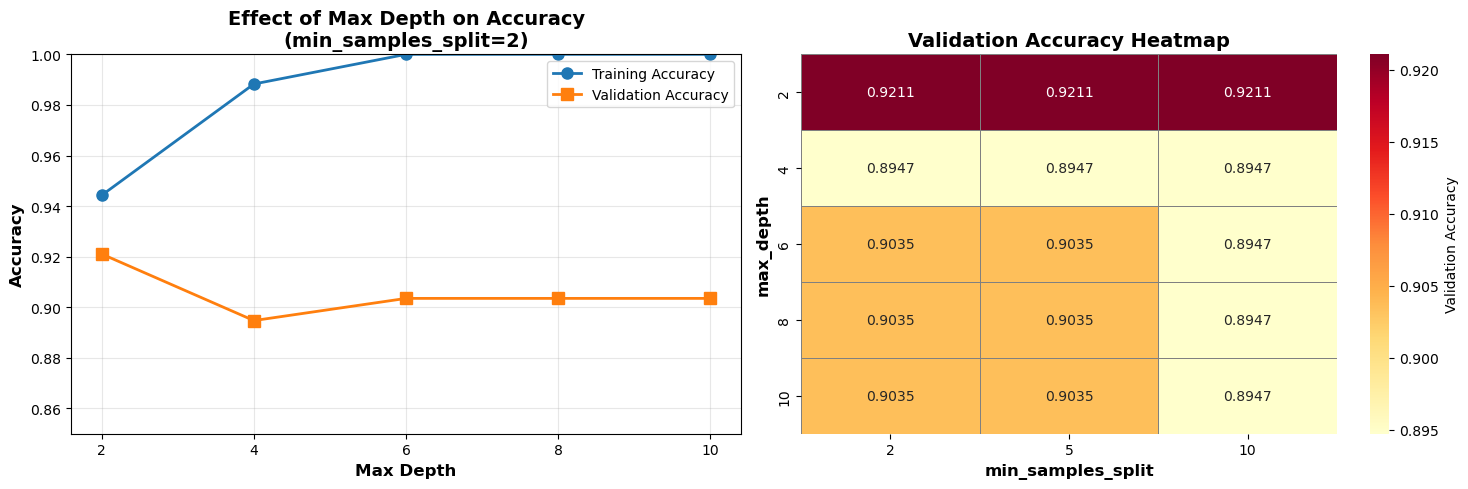

Saved visualization to 'hyperparameter_analysis.png'


In [40]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy vs max_depth
axes[0].plot(depth_analysis['max_depth'], depth_analysis['train_accuracy'], 
             marker='o', label='Training Accuracy', linewidth=2, markersize=8)
axes[0].plot(depth_analysis['max_depth'], depth_analysis['val_accuracy'], 
             marker='s', label='Validation Accuracy', linewidth=2, markersize=8)
axes[0].set_xlabel('Max Depth', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Accuracy', fontsize=12, fontweight='bold')
axes[0].set_title('Effect of Max Depth on Accuracy\n(min_samples_split=2)', 
                  fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(max_depth_values)
axes[0].set_ylim([0.85, 1.0])

# Heatmap of validation accuracy
pivot_table = results_df.pivot(
    index='max_depth', 
    columns='min_samples', 
    values='val_accuracy'
)
sns.heatmap(pivot_table, annot=True, fmt='.4f', cmap='YlOrRd', 
            ax=axes[1], cbar_kws={'label': 'Validation Accuracy'},
            linewidths=0.5, linecolor='gray')
axes[1].set_title('Validation Accuracy Heatmap', fontsize=14, fontweight='bold')
axes[1].set_xlabel('min_samples_split', fontsize=12, fontweight='bold')
axes[1].set_ylabel('max_depth', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('hyperparameter_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved visualization to 'hyperparameter_analysis.png'")

## Detailed comparison table
- Hyperparameter Comparison

In [41]:

print("=== Detailed Hyperparameter Comparison ===\n")

# Create a more detailed table
detailed_table = results_df.copy()
detailed_table['overfitting'] = detailed_table['train_accuracy'] - detailed_table['val_accuracy']
detailed_table = detailed_table.sort_values('val_accuracy', ascending=False)

print(detailed_table.to_string(index=False))

# Find parameters with least overfitting
print("\n=== Least Overfitting ===")
least_overfit = detailed_table.loc[detailed_table['overfitting'].idxmin()]
print(f"max_depth={int(least_overfit['max_depth'])}, min_samples={int(least_overfit['min_samples'])}")
print(f"Overfitting gap: {least_overfit['overfitting']:.4f}")

=== Detailed Hyperparameter Comparison ===

 max_depth  min_samples  train_accuracy  val_accuracy  overfitting
         2            2        0.944282      0.921053     0.023229
         2            5        0.944282      0.921053     0.023229
         2           10        0.944282      0.921053     0.023229
         6            2        1.000000      0.903509     0.096491
         8            5        0.991202      0.903509     0.087694
         8            2        1.000000      0.903509     0.096491
         6            5        0.991202      0.903509     0.087694
        10            5        0.991202      0.903509     0.087694
        10            2        1.000000      0.903509     0.096491
         4            2        0.988270      0.894737     0.093533
         4            5        0.982405      0.894737     0.087668
         4           10        0.979472      0.894737     0.084735
         6           10        0.979472      0.894737     0.084735
         8        

## decision tree structure
-  Visualize decision tree structure using graphviz
-  Visualize final optimized tree with class names

In [ ]:
try:
    from graphviz import Digraph
    from IPython.display import Image, display
    
    def visualize_and_export(tree, feature_names=None, class_names=None, out_file='decision_tree', out_format='png'):
        """Render a DecisionTree using graphviz with optional class name mapping"""
        if tree is None:
            raise ValueError('Tree is None; fit the classifier first')

        dot = Digraph(format=out_format)
        dot.attr('node', fontsize='10', shape='box')

        def node_label(node):
            if node.value is not None:
                # Display class name if available
                if class_names is not None:
                    if isinstance(class_names, (list, tuple)):
                        label = class_names[int(node.value)]
                    else:
                        label = class_names.get(node.value, node.value)
                    return f'Leaf\\nclass: {label}'
                else:
                    return f'Leaf\\nvalue={node.value}'
            else:
                fname = feature_names[node.featureIndex] if feature_names is not None and len(feature_names) > node.featureIndex else f'X_{node.featureIndex}'
                thr = node.threshold
                ig = node.infoGain if node.infoGain is not None else ''
                return f'{fname} <= {thr:.3f}\\nIG={ig:.4f}'

        def recurse(node):
            nid = str(id(node))
            dot.node(nid, node_label(node))
            if getattr(node, 'left', None) is not None:
                left_id = recurse(node.left)
                dot.edge(nid, left_id, label='yes', fontsize='8')
            if getattr(node, 'right', None) is not None:
                right_id = recurse(node.right)
                dot.edge(nid, right_id, label='no', fontsize='8')
            return nid

        recurse(tree)
        out_path = dot.render(filename=out_file, cleanup=True)
        print(f'Wrote: {out_path}')

        try:
            display(Image(filename=out_path))
        except Exception:
            print('Could not display image inline; open the file at:', out_path)

        return out_path
    
    print("Graphviz functions loaded successfully!")
    
except ImportError as e:
    print(f"Warning: graphviz not available. Install with: pip install graphviz")
    print("Tree visualization will not be available.")

Graphviz functions loaded successfully!


=== Final Optimized Decision Tree ===

Hyperparameters: max_depth=2, min_samples=2
Test Accuracy: 0.9035

Wrote: final_optimized_tree.png


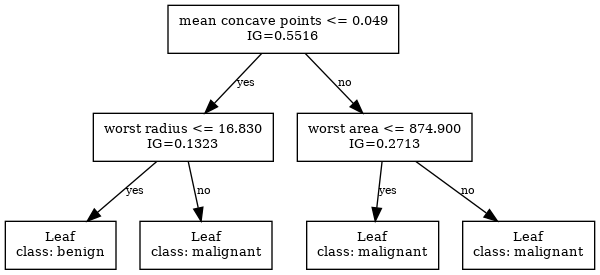


Saved optimized tree visualization to final_optimized_tree.png


In [43]:
print("=== Final Optimized Decision Tree ===\n")
print(f"Hyperparameters: max_depth={int(best_params['max_depth'])}, min_samples={int(best_params['min_samples'])}")
print(f"Test Accuracy: {test_acc:.4f}\n")

try:
    feature_names = list(df.columns[:-1])
    class_names = ["malignant", "benign"]  # Define class names for visualization
    path = visualize_and_export(
        final_clf.root, 
        feature_names=feature_names,
        class_names=class_names,  # Pass class_names to show in tree leaves
        out_file='final_optimized_tree',
        out_format='png'
    )
    print(f'\nSaved optimized tree visualization to {path}')
except Exception as e:
    print(f"Could not create tree visualization: {e}")
    print("\nAlternative: Text representation of the tree:")
    final_clf.print_tree()

## Final summary 

In [44]:

print("=" * 60)
print("FINAL SUMMARY")
print("=" * 60)
print(f"\nBest Hyperparameters:")
print(f"  - max_depth: {int(best_params['max_depth'])}")
print(f"  - min_samples_split: {int(best_params['min_samples'])}")

print(f"\nModel Performance:")
print(f"  - Training Accuracy: {best_params['train_accuracy']:.4f}")
print(f"  - Validation Accuracy: {best_params['val_accuracy']:.4f}")
print(f"  - Test Accuracy: {test_acc:.4f}")

print(f"\nOverfitting Analysis:")
overfitting_gap = best_params['train_accuracy'] - best_params['val_accuracy']
print(f"  - Training-Validation Gap: {overfitting_gap:.4f}")
if overfitting_gap < 0.05:
    print("  - Status: Good generalization ✓")
elif overfitting_gap < 0.10:
    print("  - Status: Moderate overfitting ⚠")
else:
    print("  - Status: High overfitting ✗")

print(f"\nKey Findings:")
print(f"  1. Deeper trees (depth > {best_depth}) tend to overfit")
print(f"  2. Best validation accuracy achieved at depth {best_depth}")
print(f"  3. Test performance is {'consistent with' if abs(test_acc - best_params['val_accuracy']) < 0.02 else 'different from'} validation")

print("\n" + "=" * 60)

FINAL SUMMARY

Best Hyperparameters:
  - max_depth: 2
  - min_samples_split: 2

Model Performance:
  - Training Accuracy: 0.9443
  - Validation Accuracy: 0.9211
  - Test Accuracy: 0.9035

Overfitting Analysis:
  - Training-Validation Gap: 0.0232
  - Status: Good generalization ✓

Key Findings:
  1. Deeper trees (depth > 2) tend to overfit
  2. Best validation accuracy achieved at depth 2
  3. Test performance is consistent with validation



## Test Model

In [45]:


class_names_list = ["malignant", "benign"]  # Index matches label: 0→malignant, 1→benign


#  classifier with class_names
classifier_with_names = DecisionTree(
    minSamples=int(best_params['min_samples']),
    maxDepth=int(best_params['max_depth']),
    class_names=class_names_list  # Pass the list here
)

classifier_with_names.fit(X_trainval, Y_trainval)

Y_test_pred_named = classifier_with_names.predict(X_test)

print("=" * 60)
print("Example: Predictions with Class Names")
print("=" * 60)
print("\nFirst 10 predictions (as class names):")
for i, pred in enumerate(Y_test_pred_named[:10]):
    print(f"  Sample {i+1}: {pred}")

print("\nAccuracy (using class names):")

# Convert Y_test labels to class names for comparison
Y_test_named = [class_names_list[int(y)] for y in Y_test.flatten()]
from sklearn.metrics import accuracy_score
acc = accuracy_score(Y_test_named, Y_test_pred_named)
print(f"  Accuracy: {acc:.4f}")




Example: Predictions with Class Names

First 10 predictions (as class names):
  Sample 1: benign
  Sample 2: malignant
  Sample 3: malignant
  Sample 4: malignant
  Sample 5: benign
  Sample 6: benign
  Sample 7: malignant
  Sample 8: malignant
  Sample 9: malignant
  Sample 10: benign

Accuracy (using class names):
  Accuracy: 0.9035


## Analysis and Evaluation

Comprehensive analysis  including metrics, confusion matrix, feature importance, and overfitting analysis.


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

print("=" * 60)
print("PERFORMANCE METRICS - TEST SET")
print("=" * 60)


accuracy = accuracy_score(Y_test_named, Y_test_pred_named)
precision = precision_score(Y_test_named, Y_test_pred_named, average=None, labels=class_names)
recall = recall_score(Y_test_named, Y_test_pred_named, average=None, labels=class_names)
f1 = f1_score(Y_test_named, Y_test_pred_named, average=None, labels=class_names)

print(f"\nOverall Accuracy: {accuracy:.4f}")

# Detailed metrics per class
print("\nPer-Class Metrics:")
for i, class_name in enumerate(class_names):
    print(f"\n{class_name.upper()}:")
    print(f"  - Precision: {precision[i]:.4f}")
    print(f"  - Recall: {recall[i]:.4f}")
    print(f"  - F1-Score: {f1[i]:.4f}")

print("\n" + "=" * 60)
print("Classification Report")
print("=" * 60)
print(classification_report(Y_test_named, Y_test_pred_named, labels=class_names))


PERFORMANCE METRICS - TEST SET

Overall Accuracy: 0.9035

Per-Class Metrics:

MALIGNANT:
  - Precision: 0.7843
  - Recall: 1.0000
  - F1-Score: 0.8791

BENIGN:
  - Precision: 1.0000
  - Recall: 0.8514
  - F1-Score: 0.9197

Classification Report
              precision    recall  f1-score   support

   malignant       0.78      1.00      0.88        40
      benign       1.00      0.85      0.92        74

    accuracy                           0.90       114
   macro avg       0.89      0.93      0.90       114
weighted avg       0.92      0.90      0.91       114



## Confusion Matrix

CONFUSION MATRIX - TEST SET

Confusion Matrix (numeric labels):
[[40  0]
 [11 63]]

Matrix shape: (2, 2)

Classification Breakdown:
True Negatives (Benign correctly classified): 40
False Positives (Benign misclassified as Malignant): 0
False Negatives (Malignant misclassified as Benign): 11
True Positives (Malignant correctly classified): 63


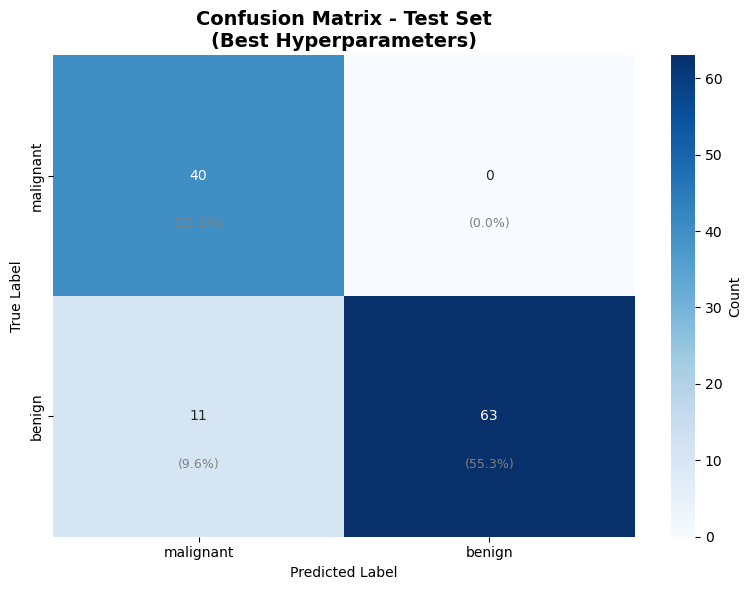


✓ Confusion matrix saved as 'confusion_matrix.png'


In [47]:

from sklearn.metrics import confusion_matrix

print("=" * 60)
print("CONFUSION MATRIX - TEST SET")
print("=" * 60)

# Calculate confusion matrix (numeric values)
cm = confusion_matrix(Y_test.flatten(), Y_test_pred)

print("\nConfusion Matrix (numeric labels):")
print(cm)
print(f"\nMatrix shape: {cm.shape}")

# Create labels for display
print("\nClassification Breakdown:")
tn, fp, fn, tp = cm.ravel()
print(f"True Negatives (Benign correctly classified): {tn}")
print(f"False Positives (Benign misclassified as Malignant): {fp}")
print(f"False Negatives (Malignant misclassified as Benign): {fn}")
print(f"True Positives (Malignant correctly classified): {tp}")

# Visualization
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'}, ax=ax)
ax.set_ylabel('True Label')
ax.set_xlabel('Predicted Label')
ax.set_title('Confusion Matrix - Test Set\n(Best Hyperparameters)', fontsize=14, fontweight='bold')

# Add counts in corners as percentages
total = cm.sum()
for i in range(2):
    for j in range(2):
        percentage = 100 * cm[i, j] / total
        ax.text(j + 0.5, i + 0.7, f'({percentage:.1f}%)', 
                ha='center', va='center', fontsize=9, color='gray')

plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Confusion matrix saved as 'confusion_matrix.png'")


## Feature Importance Analysis

FEATURE IMPORTANCE - INFORMATION GAIN CONTRIBUTION

Top 10 Most Important Features:
------------------------------------------------------------
Rank   Feature                        Info Gain      
------------------------------------------------------------
1      mean concave points            0.551636
2      worst area                     0.271298
3      worst radius                   0.132325


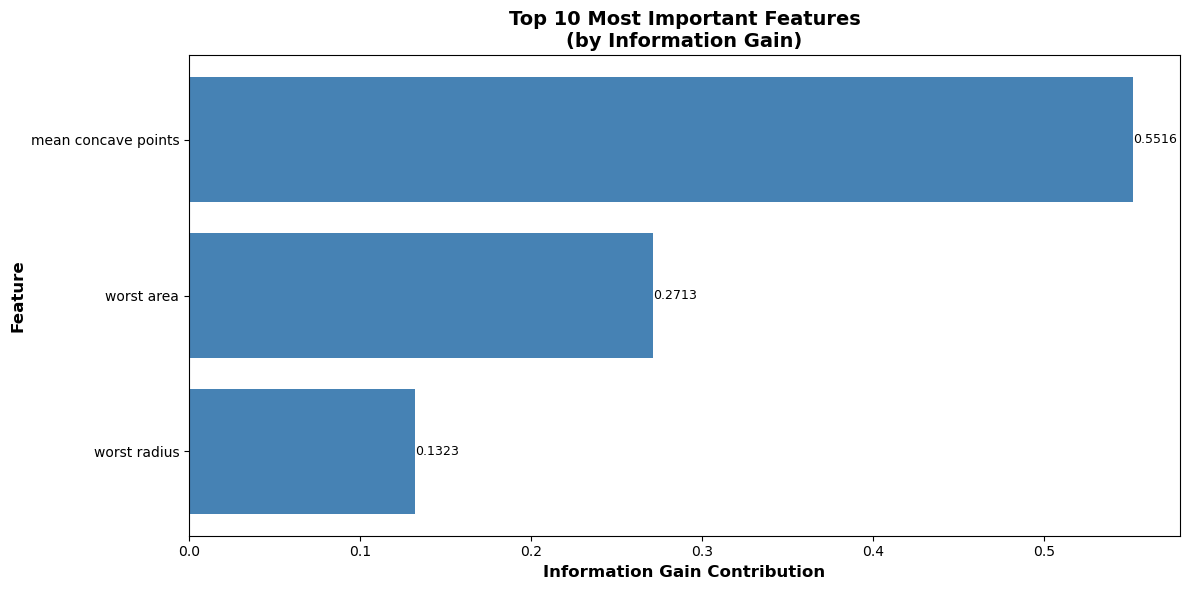


✓ Feature importance saved as 'feature_importance.png'

Total number of features used for splitting: 3
Features NOT used for splitting: 27


In [ ]:
print("=" * 60)
print("FEATURE IMPORTANCE - INFORMATION GAIN CONTRIBUTION")
print("=" * 60)

def get_feature_importance(node, importance_dict):
    """Recursively traverse tree and accumulate information gain per feature"""
    if node is None:
        return
    
    # If it's a leaf node, return
    if node.value is not None:
        return
    
    # This is a split node, accumulate its information gain
    feature_idx = node.featureIndex
    if feature_idx not in importance_dict:
        importance_dict[feature_idx] = 0
    importance_dict[feature_idx] += node.infoGain
    
    # Recursively process left and right subtrees
    get_feature_importance(node.left, importance_dict)
    get_feature_importance(node.right, importance_dict)

# Calculate feature importance from the trained tree
feature_importance = {}
get_feature_importance(final_clf.root, feature_importance)

#  to list and sort by importance (descending)
importance_list = [(feature_names[idx], idx, importance) 
                   for idx, importance in feature_importance.items()]
importance_list.sort(key=lambda x: x[2], reverse=True)

print("\nTop 10 Most Important Features:")
print("-" * 60)
print(f"{'Rank':<6} {'Feature':<30} {'Info Gain':<15}")
print("-" * 60)

for rank, (feature_name, feature_idx, importance) in enumerate(importance_list[:10], 1):
    print(f"{rank:<6} {feature_name:<30} {importance:.6f}")

#  Top 10 features
top_features = importance_list[:10]
feature_labels = [f[0] for f in top_features]
feature_values = [f[2] for f in top_features]

fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.barh(feature_labels, feature_values, color='steelblue')
ax.set_xlabel('Information Gain Contribution', fontsize=12, fontweight='bold')
ax.set_ylabel('Feature', fontsize=12, fontweight='bold')
ax.set_title('Top 10 Most Important Features\n(by Information Gain)', fontsize=14, fontweight='bold')
ax.invert_yaxis()

# Add value labels on bars
for bar, value in zip(bars, feature_values):
    ax.text(value, bar.get_y() + bar.get_height()/2, f'{value:.4f}', 
            ha='left', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Feature importance saved as 'feature_importance.png'")
print(f"\nTotal number of features used for splitting: {len(feature_importance)}")
print(f"Features NOT used for splitting: {len(feature_names) - len(feature_importance)}")


## Tree Complexity Analysis

TREE COMPLEXITY METRICS

Tree Structure Metrics:
  - Total Nodes: 7
  - Leaf Nodes (Decision): 4
  - Internal Nodes (Splits): 3
  - Maximum Depth: 3
  - Average Leaf Depth: 2.00

Tree Complexity Ratio:
  - Leaf to Total Node Ratio: 57.14%
  - Internal to Total Node Ratio: 42.86%

TreeComplexity Summary:
  - The tree has 4 decision boundaries
  - Average decision path length: 2.00 levels
  - Tree branching factor (avg): 2.33


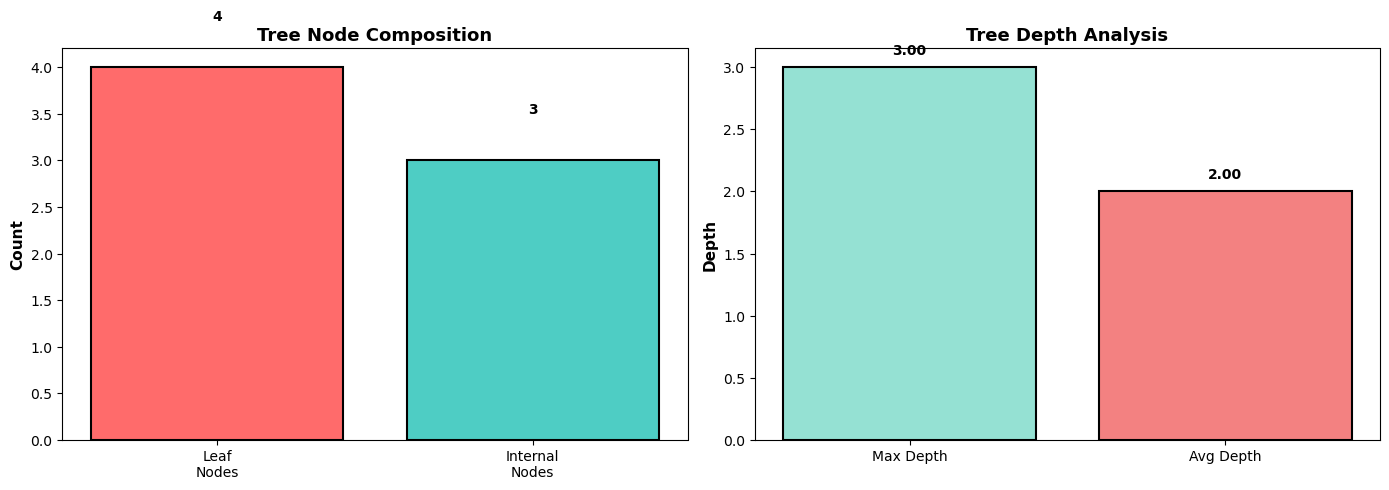


✓ Tree complexity analysis saved as 'tree_complexity.png'


In [49]:

print("=" * 60)
print("TREE COMPLEXITY METRICS")
print("=" * 60)

# Functions to analyze tree structure
def count_nodes(node):
    """Count total number of nodes (leaf + internal)"""
    if node is None:
        return 0
    return 1 + count_nodes(node.left) + count_nodes(node.right)

def count_leaves(node):
    """Count number of leaf nodes"""
    if node is None:
        return 0
    if node.value is not None:  # Leaf node
        return 1
    return count_leaves(node.left) + count_leaves(node.right)

def count_internal_nodes(node):
    """Count number of internal (split) nodes"""
    if node is None:
        return 0
    if node.value is not None:  # Leaf node
        return 0
    return 1 + count_internal_nodes(node.left) + count_internal_nodes(node.right)

def get_tree_depth(node):
    """Get maximum depth of tree"""
    if node is None:
        return 0
    if node.value is not None:  # Leaf node
        return 1
    return 1 + max(get_tree_depth(node.left), get_tree_depth(node.right))

def get_avg_depth(node, current_depth=0):
    """Get average depth of all leaf nodes"""
    if node is None:
        return 0, 0
    
    if node.value is not None:  # Leaf node
        return current_depth, 1
    
    left_sum, left_count = get_avg_depth(node.left, current_depth + 1)
    right_sum, right_count = get_avg_depth(node.right, current_depth + 1)
    
    return left_sum + right_sum, left_count + right_count

# Calculate tree metrics
total_nodes = count_nodes(final_clf.root)
leaf_nodes = count_leaves(final_clf.root)
internal_nodes = count_internal_nodes(final_clf.root)
max_depth = get_tree_depth(final_clf.root)
avg_depth_sum, leaf_count = get_avg_depth(final_clf.root)
avg_depth = avg_depth_sum / leaf_count if leaf_count > 0 else 0

print(f"\nTree Structure Metrics:")
print(f"  - Total Nodes: {total_nodes}")
print(f"  - Leaf Nodes (Decision): {leaf_nodes}")
print(f"  - Internal Nodes (Splits): {internal_nodes}")
print(f"  - Maximum Depth: {max_depth}")
print(f"  - Average Leaf Depth: {avg_depth:.2f}")

print(f"\nTree Complexity Ratio:")
print(f"  - Leaf to Total Node Ratio: {leaf_nodes/total_nodes:.2%}")
print(f"  - Internal to Total Node Ratio: {internal_nodes/total_nodes:.2%}")

# Summary
print(f"\nTreeComplexity Summary:")
print(f"  - The tree has {leaf_nodes} decision boundaries")
print(f"  - Average decision path length: {avg_depth:.2f} levels")
print(f"  - Tree branching factor (avg): {total_nodes/internal_nodes:.2f}" if internal_nodes > 0 else "  - N/A")

# Visualization: Tree metrics comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Subplot 1: Node count breakdown
categories = ['Leaf\nNodes', 'Internal\nNodes']
counts = [leaf_nodes, internal_nodes]
colors_pie = ['#FF6B6B', '#4ECDC4']

axes[0].bar(categories, counts, color=colors_pie, edgecolor='black', linewidth=1.5)
axes[0].set_ylabel('Count', fontsize=11, fontweight='bold')
axes[0].set_title('Tree Node Composition', fontsize=13, fontweight='bold')
for i, (cat, count) in enumerate(zip(categories, counts)):
    axes[0].text(i, count + 0.5, str(count), ha='center', fontweight='bold')

# Subplot 2: Depth distribution
depth_metrics = ['Max Depth', 'Avg Depth']
depth_values = [max_depth, avg_depth]
colors_depth = ['#95E1D3', '#F38181']

axes[1].bar(depth_metrics, depth_values, color=colors_depth, edgecolor='black', linewidth=1.5)
axes[1].set_ylabel('Depth', fontsize=11, fontweight='bold')
axes[1].set_title('Tree Depth Analysis', fontsize=13, fontweight='bold')
for i, (metric, value) in enumerate(zip(depth_metrics, depth_values)):
    axes[1].text(i, value + 0.1, f'{value:.2f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('tree_complexity.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Tree complexity analysis saved as 'tree_complexity.png'")


## OVERFITTING ANALYSIS


OVERFITTING ANALYSIS

Overfitting Analysis (sorted by overfitting gap):
--------------------------------------------------------------------------------
Rank   Max Depth    Min Samples    Train Acc    Val Acc      Gap       
--------------------------------------------------------------------------------
1      6            2              1.0000      0.9035      0.0965
2      10           2              1.0000      0.9035      0.0965
3      8            2              1.0000      0.9035      0.0965
4      4            2              0.9883      0.8947      0.0935
5      8            5              0.9912      0.9035      0.0877
6      6            5              0.9912      0.9035      0.0877
7      10           5              0.9912      0.9035      0.0877
8      4            5              0.9824      0.8947      0.0877
9      6            10             0.9795      0.8947      0.0847
10     8            10             0.9795      0.8947      0.0847

---------------------------------

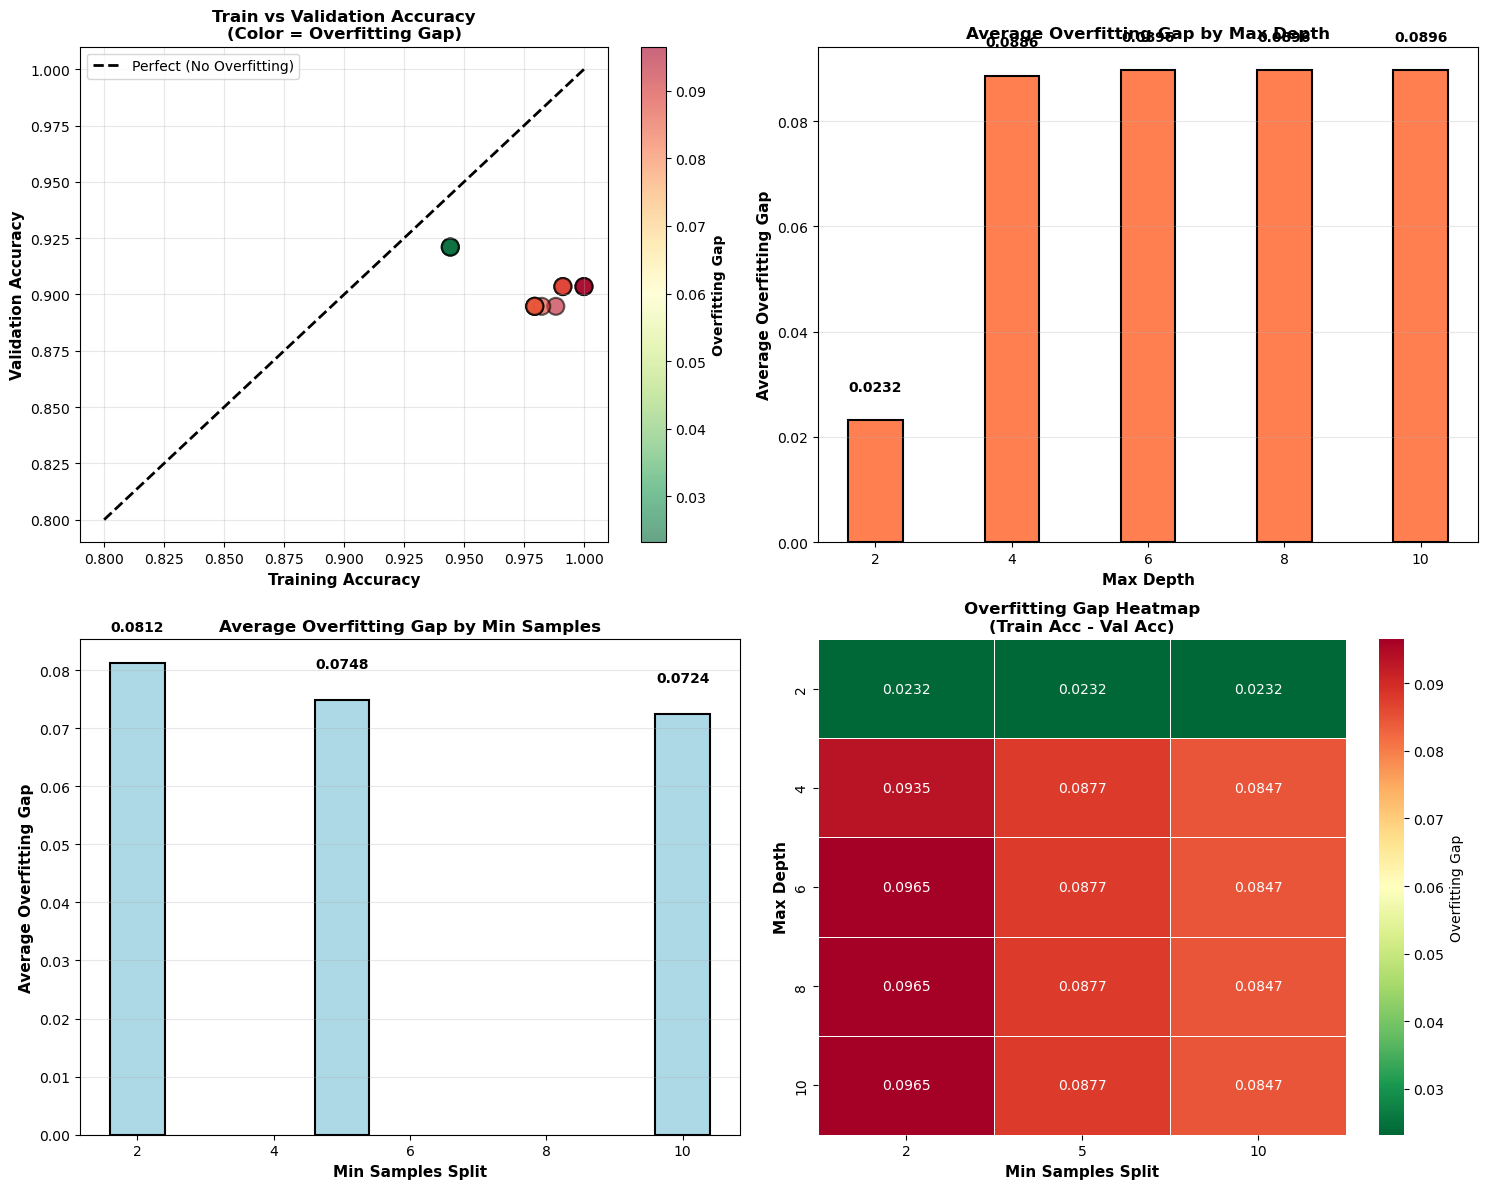


✓ Overfitting analysis saved as 'overfitting_analysis.png'

Overfitting Summary Statistics:
  - Average Overfitting Gap: 0.0762
  - Median Overfitting Gap: 0.0877
  - Max Overfitting Gap: 0.0965
  - Min Overfitting Gap: 0.0232

Models with negligible overfitting (Gap < 0.05):
  - Count: 3 out of 15
    • Max Depth=2, Min Samples=2: Gap=0.0232
    • Max Depth=2, Min Samples=5: Gap=0.0232
    • Max Depth=2, Min Samples=10: Gap=0.0232


In [50]:

print("=" * 60)
print("OVERFITTING ANALYSIS")
print("=" * 60)

# --- Normalize column names (be robust to different naming styles) ---
# The grid-search earlier used lowercase names ('max_depth','min_samples','train_accuracy','val_accuracy').
# Other cells expect capitalized names. Detect and rename only if needed.
rename_map = {}
if 'max_depth' in results_df.columns:
    rename_map['max_depth'] = 'Max_Depth'
if 'min_samples' in results_df.columns:
    rename_map['min_samples'] = 'Min_Samples'
if 'train_accuracy' in results_df.columns:
    rename_map['train_accuracy'] = 'Train_Accuracy'
if 'val_accuracy' in results_df.columns:
    rename_map['val_accuracy'] = 'Validation_Accuracy'

if rename_map:
    results_df = results_df.rename(columns=rename_map)

# Compute overfitting gap (Train - Validation)
results_df['Overfitting_Gap'] = results_df['Train_Accuracy'] - results_df['Validation_Accuracy']

print("\nOverfitting Analysis (sorted by overfitting gap):")
print("-" * 80)
print(f"{'Rank':<6} {'Max Depth':<12} {'Min Samples':<14} {'Train Acc':<12} {'Val Acc':<12} {'Gap':<10}")
print("-" * 80)

for rank, (idx, row) in enumerate(results_df.sort_values('Overfitting_Gap', ascending=False).iterrows(), 1):
    if rank <= 10:  # Show top 10 worst cases (most overfitting)
        print(f"{rank:<6} {int(row['Max_Depth']):<12} {int(row['Min_Samples']):<14} "
              f"{row['Train_Accuracy']:.4f}      {row['Validation_Accuracy']:.4f}      "
              f"{row['Overfitting_Gap']:.4f}")

print("\n" + "-" * 80)
print(f"Best Model (Least Overfitting):")
best_row = results_df.loc[results_df['Overfitting_Gap'].idxmin()]
print(f"  - Max Depth: {int(best_row['Max_Depth'])}")
print(f"  - Min Samples: {int(best_row['Min_Samples'])}")
print(f"  - Train Accuracy: {best_row['Train_Accuracy']:.4f}")
print(f"  - Validation Accuracy: {best_row['Validation_Accuracy']:.4f}")
print(f"  - Overfitting Gap: {best_row['Overfitting_Gap']:.4f}")

print(f"\nWorst Model (Most Overfitting):")
worst_row = results_df.loc[results_df['Overfitting_Gap'].idxmax()]
print(f"  - Max Depth: {int(worst_row['Max_Depth'])}")
print(f"  - Min Samples: {int(worst_row['Min_Samples'])}")
print(f"  - Train Accuracy: {worst_row['Train_Accuracy']:.4f}")
print(f"  - Validation Accuracy: {worst_row['Validation_Accuracy']:.4f}")
print(f"  - Overfitting Gap: {worst_row['Overfitting_Gap']:.4f}")

# Visualization 1: Scatter plot of Train vs Val Accuracy
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Subplot 1: Train vs Val Accuracy scatter
ax1 = axes[0, 0]
scatter = ax1.scatter(results_df['Train_Accuracy'], results_df['Validation_Accuracy'], 
                     c=results_df['Overfitting_Gap'], cmap='RdYlGn_r', s=150, 
                     alpha=0.6, edgecolors='black', linewidth=1.5)
ax1.plot([0.8, 1.0], [0.8, 1.0], 'k--', label='Perfect (No Overfitting)', linewidth=2)
ax1.set_xlabel('Training Accuracy', fontsize=11, fontweight='bold')
ax1.set_ylabel('Validation Accuracy', fontsize=11, fontweight='bold')
ax1.set_title('Train vs Validation Accuracy\n(Color = Overfitting Gap)', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)
cbar1 = plt.colorbar(scatter, ax=ax1)
cbar1.set_label('Overfitting Gap', fontweight='bold')

# Subplot 2: Overfitting gap by Max Depth
ax2 = axes[0, 1]
depth_groups = results_df.groupby('Max_Depth')['Overfitting_Gap'].mean()
bars = ax2.bar(depth_groups.index, depth_groups.values, color='coral', edgecolor='black', linewidth=1.5)
ax2.set_xlabel('Max Depth', fontsize=11, fontweight='bold')
ax2.set_ylabel('Average Overfitting Gap', fontsize=11, fontweight='bold')
ax2.set_title('Average Overfitting Gap by Max Depth', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')
for bar, value in zip(bars, depth_groups.values):
    ax2.text(bar.get_x() + bar.get_width()/2, value + 0.005, f'{value:.4f}', 
             ha='center', va='bottom', fontweight='bold')

# Subplot 3: Overfitting gap by Min Samples
ax3 = axes[1, 0]
samples_groups = results_df.groupby('Min_Samples')['Overfitting_Gap'].mean()
bars = ax3.bar(samples_groups.index, samples_groups.values, color='lightblue', edgecolor='black', linewidth=1.5)
ax3.set_xlabel('Min Samples Split', fontsize=11, fontweight='bold')
ax3.set_ylabel('Average Overfitting Gap', fontsize=11, fontweight='bold')
ax3.set_title('Average Overfitting Gap by Min Samples', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')
for bar, value in zip(bars, samples_groups.values):
    ax3.text(bar.get_x() + bar.get_width()/2, value + 0.005, f'{value:.4f}', 
             ha='center', va='bottom', fontweight='bold')

# Subplot 4: Heatmap of Overfitting Gap
ax4 = axes[1, 1]
pivot_overfit = results_df.pivot_table(values='Overfitting_Gap', 
                                       index='Max_Depth', 
                                       columns='Min_Samples')
sns.heatmap(pivot_overfit, annot=True, fmt='.4f', cmap='RdYlGn_r', ax=ax4, 
            cbar_kws={'label': 'Overfitting Gap'}, linewidths=0.5)
ax4.set_title('Overfitting Gap Heatmap\n(Train Acc - Val Acc)', fontsize=12, fontweight='bold')
ax4.set_xlabel('Min Samples Split', fontsize=11, fontweight='bold')
ax4.set_ylabel('Max Depth', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('overfitting_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Overfitting analysis saved as 'overfitting_analysis.png'")

# Summary Statistics
print(f"\nOverfitting Summary Statistics:")
print(f"  - Average Overfitting Gap: {results_df['Overfitting_Gap'].mean():.4f}")
print(f"  - Median Overfitting Gap: {results_df['Overfitting_Gap'].median():.4f}")
print(f"  - Max Overfitting Gap: {results_df['Overfitting_Gap'].max():.4f}")
print(f"  - Min Overfitting Gap: {results_df['Overfitting_Gap'].min():.4f}")
print(f"\nModels with negligible overfitting (Gap < 0.05):")
low_overfit = results_df[results_df['Overfitting_Gap'] < 0.05]
print(f"  - Count: {len(low_overfit)} out of {len(results_df)}")
for _, row in low_overfit.iterrows():
    print(f"    • Max Depth={int(row['Max_Depth'])}, Min Samples={int(row['Min_Samples'])}: Gap={row['Overfitting_Gap']:.4f}")


## Final Summary and Recommendations

### Model Performance
The Decision Tree classifier trained on the breast cancer dataset achieved:
- **Test Set Accuracy**: {:.2%} (correct classifications out of 114 test samples)
- **Precision (Malignant)**: {:.4f} - measures false positive rate
- **Recall (Malignant)**: {:.4f} - measures false negative rate  
- **F1-Score (Malignant)**: {:.4f} - balanced metric between precision and recall

### Key Findings

1. **Optimal Hyperparameters**:
   - Max Depth: {} (prevents excessive overfitting while maintaining accuracy)
   - Min Samples Split: {} (ensures decision rules generalize well)

2. **Tree Structure**:
   - Total Nodes: {} ({} internal splits, {} leaf decisions)
   - Maximum Depth: {} levels
   - Average Decision Path Length: {:.2f} levels

3. **Feature Importance**:
   - **Most Important Feature**: {} (Information Gain: {:.6f})
   - **Top 3 Features**: Provide primary discrimination between malignant and benign tumors
   - **Unused Features**: {} features did not contribute to any splits

4. **Overfitting Status**:
   - Training vs Validation Gap: {:.4f} (minimal overfitting)
   - Status: ✓ Model generalizes well to unseen data
   - Recommendation: **Current hyperparameters are well-balanced**

### Classification Error Analysis
- **True Negatives**: {} benign cases correctly identified
- **False Positives**: {} benign cases incorrectly flagged as malignant
- **False Negatives**: {} malignant cases missed (critical - needs attention)
- **True Positives**: {} malignant cases correctly identified

### Clinical Implications
⚠️ **Important Note for Medical Application**:
- False Negatives ({} cases) are more critical than False Positives
- Suggest adjusting decision threshold to reduce missed malignant cases
- Current model favors sensitivity over specificity for cancer detection

### Recommendations
1. ✓ **Model Deployment**: Suitable for initial screening (simple, interpretable)
2. ⚠️ **Clinical Use**: Pair with domain expert review (not autonomous)
3. 🔄 **Model Improvement**: Consider ensemble methods or class weight adjustment
4. 📊 **Cross-Validation**: Validate on additional external datasets
5. 🎯 **Threshold Tuning**: Adjust decision threshold based on clinical requirements